In [1]:
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import check_random_state

# Turn down for faster convergence
train_samples = 5_000

# Load data from https://www.openml.org/d/554
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation].astype(np.float32)
y = y[permutation].astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=1000
)

y_train = y_train.astype(int)
y_test = y_test.astype(int)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = np.reshape(X_train, newshape=[X_train.shape[0], 1, 28, 28])
X_test = np.reshape(X_test, newshape=[X_test.shape[0], 1, 28, 28])

ohe = OneHotEncoder()
ohe.fit(y_train.reshape(-1, 1))
# y_train = ohe.transform(y_train.reshape(-1, 1))
# y_test = ohe.transform(y_test.reshape(-1, 1))

C:\MySpace\Programs\anaconda3\envs\cvenv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


OneHotEncoder()

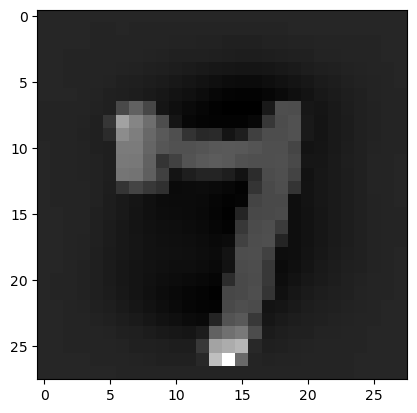

In [2]:
from matplotlib import pyplot as plt

img = X_train[6].reshape([28, 28, 1]).copy()
plt.imshow(img, cmap='gray')

In [3]:
from lab1.tn3.activations import Sigmoid, Softmax, Relu
from lab1.tn3.layers import Conv2D, MaxPooling, FC, Flatten, BatchNormLayer, Dropout, BatchNorm2D
from lab1.tn3.base import Module, Sequential
from lab1.tn3.loss import CrossEntropyLoss
from lab1.tn3.optim import SGD, AdaSmooth
from lab1.tn3.models.alexnet import AlexNet

#
# class Model(Module):
#     def __init__(self):
#         super(Model, self).__init__()
#         self.layers = [
#             Sequential('block1', [
#                 Conv2D(name="conv1", in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=1),  # 1*28*28
#             MaxPooling('pool1', ksize=2, stride=2),  # 6*14*14
#             Relu(name='relu')
#             ]),
#
#             Conv2D(name="conv2", in_channels=6, out_channels=12, kernel_size=3, stride=1, padding=1),
#             MaxPooling('pool2', ksize=2, stride=2),  # 12*7*7
#             Relu(name='relu2'),
#
#             Flatten('flat'),
#             FC(name="full1", in_channels=37632, out_channels=256),
#             Relu(name="sigmoid1"),
#             BatchNormLayer(name='bn2', dims=256),
#             FC(name="full3", in_channels=256, out_channels=10),
#             Softmax('softmax')
#         ]

class Model(Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layers = [
            Conv2D(name='conv1', in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            Relu(name='relu1'),
            BatchNorm2D(name='bn2', n_channels=8),
            # Dropout(name='drop', prob=0.8),
            Conv2D(name='conv2', in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1),
            Relu(name='relu2'),
            BatchNorm2D(name='bn2', n_channels=8),
            MaxPooling(name='pooling2', ksize=3, stride=1),
            Flatten('flat'),
            FC(name="full1", in_channels=5408, out_channels=10),
            # Relu(name="relu2"),
            # BatchNormLayer(dims=256, name='bn1'),
            # FC(name="full2", in_channels=256, out_channels=128),
            # Relu(name="relu3"),
            # BatchNormLayer(dims=128, name='bn2'),
            # FC(name="full3", in_channels=128, out_channels=10),
            Softmax('softmax')
        ]

model = AlexNet()

In [4]:
model.train()
out = model.forward(np.random.random((1, 3, 227, 227)))
out
# out = model.forward(np.random.randn(1, 1, 28, 28))
# out

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [5]:
model.params

[[{'weights': {'value': array([[[[ 1.50399748e+00, -5.26356061e-01, -1.28631575e-01, ...,
              -1.65926104e+00,  1.48350220e+00, -5.59272426e-01],
             [ 9.20524829e-01,  1.55148907e+00, -2.00432480e+00, ...,
              -1.69297677e+00, -1.01636403e-01, -1.74050168e-01],
             [ 9.04985151e-01,  1.35745951e+00, -1.40253778e+00, ...,
               5.31686605e-02,  6.38089495e-01, -5.63510894e-02],
             ...,
             [ 1.21272820e+00, -1.17895885e-01,  1.97567509e+00, ...,
              -2.36587770e-01,  7.41516623e-04, -5.70325527e-01],
             [-1.88214012e+00,  2.55045688e+00, -2.05526654e-01, ...,
               1.57494590e+00,  1.16269276e+00,  5.62768990e-01],
             [-2.08208255e+00,  1.19912172e+00,  1.44865971e-01, ...,
              -1.82893784e+00, -1.14010169e+00, -5.43083150e-01]],
    
            [[-4.30385600e-01,  1.87895143e-01, -6.46500976e-01, ...,
               6.51289333e-01, -1.37295239e+00, -2.91923262e-01],
    

In [6]:
from lab1.tn3.loss import MSELoss

cel = CrossEntropyLoss()
crit = AdaSmooth(model.layers, lr=0.005)

In [7]:
from lab1.tn3.data import Dataset, Dataloader

dataset_train = Dataset(data=X_train, target=y_train)
dataloader_train = Dataloader(dataset=dataset_train, batch_size=8, shuffle=True)


dataset_test = Dataset(data=X_test, target=y_test)
dataloader_test = Dataloader(dataset=dataset_test, batch_size=8)

In [8]:
from tqdm import tqdm
import cv2

def accuracy(pred, true):
    pred_int = np.argmax(pred, axis=1)
    return np.sum(pred_int == true) / pred.shape[0]

def convert_img(imgs):
    new_imgs = list()
    for img in imgs:
        img = img.reshape((28, 28, 1))
        img = np.concatenate([img, img, img], axis=2)
        img = np.array(cv2.resize(img, dsize=(227, 227)), dtype='float64')
        img = img.reshape(3, 227, 227)
        new_imgs.append(np.expand_dims(img, axis=0))
    return np.concatenate(new_imgs, axis=0)

def train_epoch(epoch: int):
    model.train()
    full_loss = 0
    with tqdm(total=len(dataloader_train)) as t:
        for j, samples in enumerate(dataloader_train):
            data, targets = samples
            crit.zero_grad()
            data = convert_img(data)
            out = model.forward(data / 255)
            lbl_ohe = np.zeros_like(out)
            lbl_ohe[list(range(out.shape[0])), targets] = 1
            loss, grad = cel(out, targets)
            full_loss += loss
            model.backward(grad)
            crit.update()
            t.update(1)
            t.set_description(f'Train epoch: {epoch} | Loss: {full_loss / (j + 1)}')

def evaluate(epoch: int):
    acc = 0
    model.eval()
    with tqdm(total=len(dataloader_test)) as t:
        for j, samples in enumerate(dataloader_test):
            data, targets = samples
            crit.zero_grad()
            converted = convert_img(data)
            # data = data.astype('float64')
            converted = data
            out = model.forward(converted / 255)
            acc += accuracy(out, targets)
            t.update(1)
            t.set_description(f'Test epoch: {epoch} | Accuracy {acc / (j + 1)}')

for i in range(30):
    train_epoch(i + 1)
    evaluate(i + 1)

Train epoch: 1 | Loss: 25.576559416575986:  19%|█▊        | 116/625 [21:42<1:35:16, 11.23s/it]


KeyboardInterrupt: 

In [ ]:
# 30 эпох, 82.7% точность, окно 10, 1 сверточный слой
# 30 эпох, 85.3% точность, окно 30, 1 сверточный слой
# 60 эпох, 84.9% точность, окно 30, 2 сверточных слоя


In [ ]:
model.params

In [ ]:
import numpy as np
test_arr = np.random.randn(1, 1, 28, 28)
grad_arr = np.random.randn(1, 3, 28, 28)

np_conv = Conv2D(name='conv_test', in_channels=1, out_channels=3, kernel_size=3, stride=1, padding=1)
np_conv.forward(test_arr)
np_grad = np_conv.backward(grad_arr)

from torch import nn
import torch

torch_conv = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=1, padding=1)
torch_out = torch_conv(torch.autograd.Variable(torch.tensor(test_arr, dtype=torch.float32, requires_grad=True)))
loss = torch_out - torch.zeros_like(torch_out)
loss.backward()
np_grad.shape, torch_out.grad

In [ ]:
k = 456

model.eval()
# print(convert_img(X_test[k]).shape)
out = model.forward(np.expand_dims(X_test[k], axis=0).astype('float64') / 255)
print(out)
out.argmax(), y_test[k]

In [ ]:
import cv2
from PIL import Image
from lab1.tn3.models.alexnet import AlexNet

alex = AlexNet()

img = dataloader_train[0][0][0].reshape((28, 28, 1))
img = np.concatenate([img, img, img], axis=2)
img = cv2.resize(img, dsize=(224, 224))
plt.imshow(img)

In [ ]:
img = np.expand_dims(img.reshape(3, 224, 224), axis=0)
alex.forward(img)

In [ ]:
import skimage

print(img.shape)
np.argmax(img, 1) // 3, np.argmax(img, 1) % 3